In [189]:
#import sys
#!{sys.executable} -m pip install numpy --upgrade
#!{sys.executable} -m pip install pandas --upgrade
#!{sys.executable} -m pip install matplotlib --upgrade
#!{sys.executable} -m pip install sklearn --upgrade


import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')



# Get the current working directory
cwd = os.getcwd()

# Print the current working directory
print("Current working directory: {0}".format(cwd))
os.chdir('../PumpDataDiscovery')
cwd = os.getcwd()
print("Current working directory: {0}".format(cwd))

Current working directory: /Users/eliguidera/jupyter/venv3-8/PumpDataDiscovery
Current working directory: /Users/eliguidera/jupyter/venv3-8/PumpDataDiscovery


In [190]:
def get_null_list(df):
    """Get list of sums of nulls.
    Get list by columns showing how many nulls are in each column
    :param df: DataFrame
    :type: Pandas DataFrame
    :return: List of sums of nulls
    :type: List
    """
    nulls_series = df.isnull().sum()
    return nulls_series

In [191]:
def drop_bad_cols(df, col_list):
    """Drop unusable columns inplace

    :param df: DataFrame
    :type: Pandas DataFrame
    :param col_list: List of unusable column names
    :return: none
    """
    df.drop(col_list, axis=1, errors='ignore', inplace=True)

In [192]:
def machine_status_to_numeric(df):
    """Make 'machine_status" column numeric
    Numeric values are 0: 'NORMAL';, 1: 'BROKEN', 0.5: 'RECOVERING'
    :param df: DataFrame
    :type: Pandas DataFrame
    :return: none
    """
    status_values = [(df['machine_status'] == 'NORMAL'), (df['machine_status'] == 'BROKEN'),
                     (df['machine_status'] == 'RECOVERING')]
    numeric_status_values = [0, 1, 0.5]

    df['machine_status'] = np.select(status_values, numeric_status_values, default=0)

In [193]:
def get_failure_times(df):
    """Get DataFrame of rows where 'machine_status' has a value of 1

    :param df: DataFrame
    :return: Failure times
    :type: DatetimeIndex
    """
    return df[df['machine_status'] == 1].index


In [194]:
def plot_specific_cols(df):
    df[['sensor_03', 'sensor_04', 'sensor_21', 'machine_status']].plot( kind='line', 
                                             figsize=(10,4),subplots=True)
    plt.tight_layout()
    plt.show()

In [195]:
def get_failure_times(df):
    """Get DataFrame of rows where 'machine_status' has a value of 1

    :param df: DataFrame
    :return: Failure times
    :type: DatetimeIndex
    """
    return df[df['machine_status'] == 1].index

In [196]:
def separate_data(df, failure_times):
    """Slice data by failure times
    If there are 7 failure times, then produce 7 slices as DataFrames

    :param df: All Data
    :type: Pandas DataFrame
    :param failure_times: DatetimeIndex
    :return: DataFrames for training, validation and testing
    :type: tuple of DataFrames
    """
    df_val = df.loc[:(failure_times[0] + pd.Timedelta(seconds=60 * 120)), :]
    df_test = df.loc[(failure_times[0] + pd.Timedelta(seconds=60 * 120)):(
            failure_times[1] + pd.Timedelta(seconds=60 * 120)), :]
    df_train = df.loc[failure_times[1] + pd.Timedelta(seconds=60 * 120):, :]

    return df_train, df_val, df_test

In [197]:
def replace_nan_with_mean(df):
    """
    First replace all empty cells with NaN
    Then replace NaN columnwise with mean of each column inplace
    :param df: DataFrame
    :type: Pandas DataFrame
    :return: none
    """
    cols = df.columns
    df_no_blank = df.replace(r'^\s*$', np.nan, regex=True)
    df.fillna(value=df_no_blank[cols].mean(), inplace=True)

In [198]:
def get_scaler(training_df):
    """Get a scaler for training data
    Apply MinManScaler to the training data using the range (0, 1)
    :param training_df:
    :type: Pandas DataFrame
    :param sensor_names: List of sensor names(feature names)
    :type: list
    :return: scaler for the training data
    :type: MinMaxScaler
    """
    sensor_names = training_df.columns[:-2]
    min_max_scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = min_max_scaler.fit(training_df[sensor_names])

    return scaler

In [199]:
def scale_dataframe(scaler, data_df):
    """Transform given dataframe using given scaler as applied to the given columns

    :param scaler: The scaler that has been fit to the dataframe
    :type: MinMaxScaler
    :param data_df: Dataframe to be scaled
    :type: Pandas DataFrame
    :param sensor_names: List of sensor names
    :type: List of string
    :return: array of scaled data
    :type: ndarray
    """
    sensor_names = data_df.columns[:-2]
    scaled_data = scaler.transform(data_df[sensor_names])
    return scaled_data

In [200]:
def get_PCA(train_scaled_data, num_components=None):
    """Get PCA that has been fit to the scaled training data
    PCA is the Principal Component Analysis.  Training data features are each ranked by their maximum variance from
    all the other features.
    :param train_scaled_data: scaled training data
    :type: ndarray
    :param num_components: Number of features in the training data
    :return: Fit PCA
    :type: PCA
    """
    pca = PCA(n_components=num_components).fit(train_scaled_data)
    return pca

In [201]:
def plot_pca(pca, n_features):
    #pca = PCA().fit(data_rescaled)


    plt.rcParams["figure.figsize"] = (12,6)

    fig, ax = plt.subplots()
    xi = np.arange(1, n_features, step=1)
    y = np.cumsum(pca.explained_variance_ratio_)

    plt.ylim(0.0,1.1)
    plt.plot(xi, y, marker='o', linestyle='--', color='b')

    plt.xlabel('Number of Components')
    plt.xticks(np.arange(1, n_features, step=1)) #change from 0-based array index to 1-based human-readable label
    plt.ylabel('Cumulative variance (%)')
    plt.title('The number of components needed to explain variance')

    plt.axhline(y=0.95, color='r', linestyle='-')
    plt.text(25, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

    ax.grid(axis='x')
    plt.show()

In [202]:
def transform_df_by_pca(pca, df_data, scaled_data, num_pc_to_include):
    """Reduce the number of features in the training data by the parameter num_features_to_include.

    :param pca: The PCA for the training data
    :type: PCA
    :param df_data: data dataframe
    :type: Pandas DataFrame
    :param scaled_data: Array of scaled data
    :type: ndarray
    :param num_pc_to_include: Number of features to include.  Currently, this number is determined
    by the num of PC's that were chosen by the PCA to reach 95% ( sum of explained_variance_ratio)
    :type: int
    
    :return: DataFrame with data that has been scaled and whose dimensions have been reduced.  This DataFrame has
    the same index as the param df_data
    :type: Pandas DataFrame
    """

    data_transformed = pca.transform(scaled_data)  # ndarray
    df_transformed = pd.DataFrame(data_transformed)
    pcs = ['pc' + str(i + 1) for i in range(pca.n_components_)]
    df_transformed.columns = pcs

    df_transformed.index = df_data.index
    df_smaller = df_transformed[pcs[:num_pc_to_include]]
    df_smaller['machine_status'] = df_data['machine_status'].values

    return df_smaller

## Get Data 
Read the data into a dataframe, set the dataframe's index to the 'timestamp' column and parse the dates so that they become datetime objects.  Get a count of null values for each column.

In [203]:
df = pd.read_csv('sensor.csv', index_col='timestamp', parse_dates=True)
#df.index = pd.to_datetime(df.index)
nulls_series = get_null_list(df)
print(nulls_series)


Unnamed: 0             0
sensor_00          10208
sensor_01            369
sensor_02             19
sensor_03             19
sensor_04             19
sensor_05             19
sensor_06           4798
sensor_07           5451
sensor_08           5107
sensor_09           4595
sensor_10             19
sensor_11             19
sensor_12             19
sensor_13             19
sensor_14             21
sensor_15         220320
sensor_16             31
sensor_17             46
sensor_18             46
sensor_19             16
sensor_20             16
sensor_21             16
sensor_22             41
sensor_23             16
sensor_24             16
sensor_25             36
sensor_26             20
sensor_27             16
sensor_28             16
sensor_29             72
sensor_30            261
sensor_31             16
sensor_32             68
sensor_33             16
sensor_34             16
sensor_35             16
sensor_36             16
sensor_37             16
sensor_38             27


## Null count for each column
Make a list of columns that have too many nulls and remove those columns from the dataframe.

In [204]:
bad_col_list = ['Unnamed: 0', 'sensor_00', 'sensor_15', 'sensor_50', 'sensor_51']
drop_bad_cols(df, bad_col_list)

## Convert 'machine_status' values with numerics
Convert the textual machine_status values, 'BROKEN', 'NORMAL', 'RECOVERING' to numeric values

In [205]:
machine_status_to_numeric(df)
df.head()

,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,...,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,machine_status
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,...,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,0.0
2018-04-01 00:01:00,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,...,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,0.0
2018-04-01 00:02:00,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,...,30.46875,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,0.0
2018-04-01 00:03:00,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,38.57977,...,30.46875,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,0.0
2018-04-01 00:04:00,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,39.48939,...,30.98958,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,0.0


## Plot some sensor data
Plot three sensor values and compare the plots to the plot of the machine_status column.

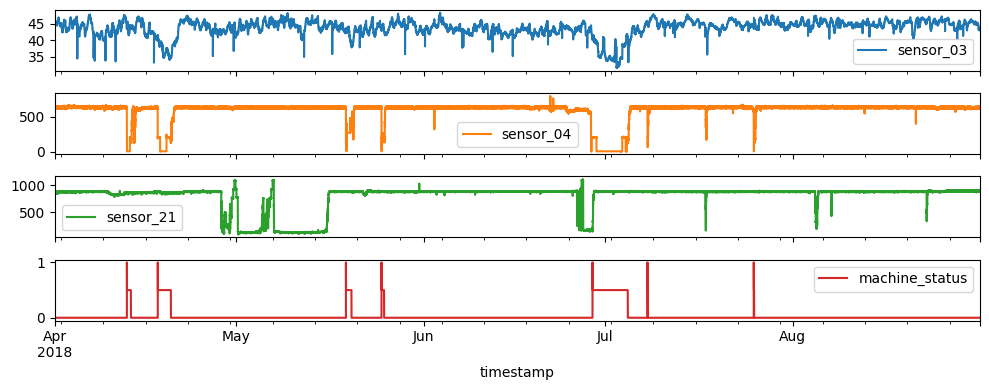

In [206]:
plot_specific_cols(df)

## Replace blank and NaN values with mean for each column
Replace all blank values in the dataframe with NaN and then replace all NaN values with the mean of each column.

In [207]:
replace_nan_with_mean(df)

## Get failure times
Get all failure times.  

In [208]:
failure_times = get_failure_times(df)
print("Failure times: {}".format(failure_times))

Failure times: DatetimeIndex(['2018-04-12 21:55:00', '2018-04-18 00:30:00',
               '2018-05-19 03:18:00', '2018-05-25 00:30:00',
               '2018-06-28 22:00:00', '2018-07-08 00:11:00',
               '2018-07-25 14:00:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None)


## Split data by failure times
Separate data into training, validation and test dataframes.  The slicing will be done as follows:
    
    Validation data will consist of all rows from the start of the data file to two minutes after the first failure time
    Test data will consist of all rows from two minutes after the first failure to two minutes after the second failure time
    Training data will consist of all rows from two minutes after the second failure to the end of the data file.

In [209]:
df_train, df_val, df_test = separate_data(df, failure_times)

## Create a MinMaxScaler for training data
Fit a MinMaxScaler to the training data

In [210]:
training_scaler = get_scaler(df_train)

## Transform all data using MinMaxScaler that was fit to training data
Scale transform the training, validation, and test data using the training scaler.

In [211]:
scaled_train = scale_dataframe(training_scaler, df_train)
scaled_val = scale_dataframe(training_scaler, df_val)
scaled_test = scale_dataframe(training_scaler, df_test)


## Create a PCA that is fit on the training data
Fit the scaled training data with a PCA analysis.  Plot the cumulative sum of the variance to determine how many PC's 
are needed to reach 95% of the threshold.

The Principal Component Analysis (PCA) makes linear combinations ( Called Principal Components) of all the features and then ranks those combinations by their per cent contribution to the total variance. We then see how many Principal
Components we need to account for a threshold of 95% of the total variance.  We will see by the graph generated that we will need 12 PC's to account for 95%.

We will then use 12 PC's instead of 47 sensors to do our model training, testing and prediction.  So by using the PCA transformation, we reduce our need for 47 features to only 12 features.

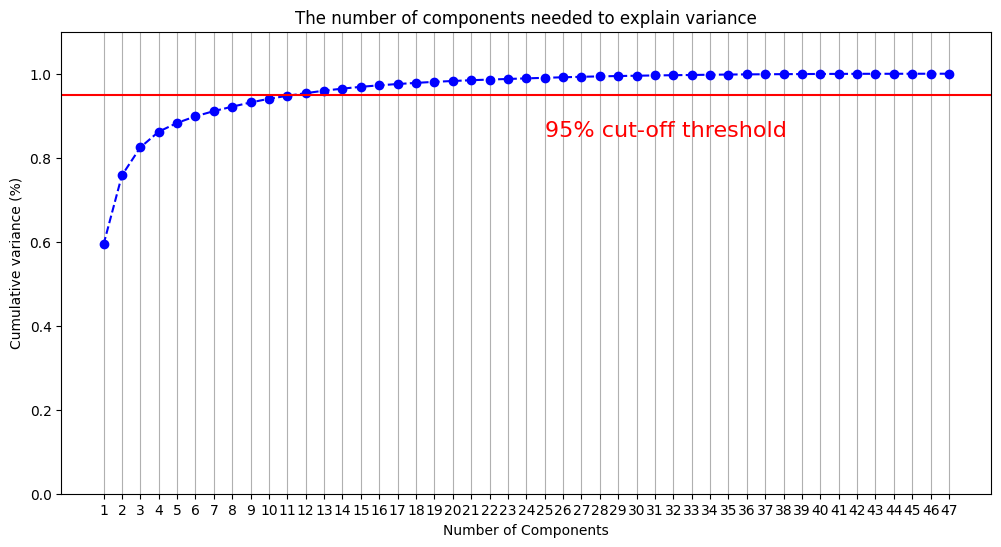

In [212]:
pca = get_PCA(scaled_train)
plot_pca(pca, len(df_train.columns) - 1)

## Transform all the data using the fitted PCA
Transform the scaled training, validation and test data using the fitted PCA 

In [213]:
num_pc_to_include = 12
df_train_pca = transform_df_by_pca(pca, df_train, scaled_train, num_pc_to_include)
df_val_pca = transform_df_by_pca(pca, df_val, scaled_val, num_pc_to_include)
df_test_pca = transform_df_by_pca(pca, df_test, scaled_test, num_pc_to_include)


In [214]:
df_train_pca.head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,machine_status
timestamp,,,,,,,,,,,,,
2018-04-18 02:30:00,-0.128641,1.410076,0.194306,0.446849,-0.380950,-0.105999,0.068558,0.171579,-0.020029,-0.089618,0.042070,-0.047774,0.5
2018-04-18 02:31:00,-0.121417,1.417852,0.173372,0.437315,-0.392624,-0.086322,0.044358,0.173201,-0.005303,-0.070027,0.031231,-0.048875,0.5
2018-04-18 02:32:00,-0.126777,1.422542,0.161684,0.427027,-0.401568,-0.081803,0.015023,0.177289,-0.005135,-0.052899,0.032534,-0.057414,0.5
2018-04-18 02:33:00,-0.119010,1.417832,0.174297,0.433716,-0.394863,-0.097057,0.022641,0.175827,-0.011169,-0.062327,0.041721,-0.052791,0.5
2018-04-18 02:34:00,-0.128034,1.416018,0.173724,0.433398,-0.393999,-0.087187,0.039675,0.172969,-0.011848,-0.064721,0.038477,-0.048677,0.5
